# Laurence Ashraf 202200667

# Final project DSAI 308 Deep learning course: CNN model for pneumonia disease detection

## installing and importing needed libraries

In [1]:
!pip install LIME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for LIME: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=68046f97a45900baa4d7fb0c41eee752bb3605bfc4c73a3c77d103e1bd7ad28d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built LIME


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

## load the data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


## Preprocessing and EDA techniques

### Tracking directories

In [4]:
all_images = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append(os.path.join(root, file))

#### collecting each type in a list

In [5]:
train_normal_dirs = []
train_pneumonia_dirs = []

test_normal_dirs = []
test_pneumonia_dirs = []

val_normal_dirs = []
val_pneumonia_dirs = []

for j in range(len(all_images)):
  if all_images[j].find('train') != -1:  #collect train dirs
    if all_images[j].find('NORMAL') != -1:
      train_normal_dirs.append(all_images[j])
    if all_images[j].find('PNEUMONIA') != -1:
      train_pneumonia_dirs.append(all_images[j])

  if all_images[j].find('test') != -1: #collect test dirs
    if all_images[j].find('NORMAL') != -1:
      test_normal_dirs.append(all_images[j])
    if all_images[j].find('PNEUMONIA') != -1:
      test_pneumonia_dirs.append(all_images[j])

  if all_images[j].find('val') != -1: #collect val dirs
    if all_images[j].find('NORMAL') != -1:
      val_normal_dirs.append(all_images[j])
    if all_images[j].find('PNEUMONIA') != -1:
      val_pneumonia_dirs.append(all_images[j])

#### EDA techniques: plotting samples from training category

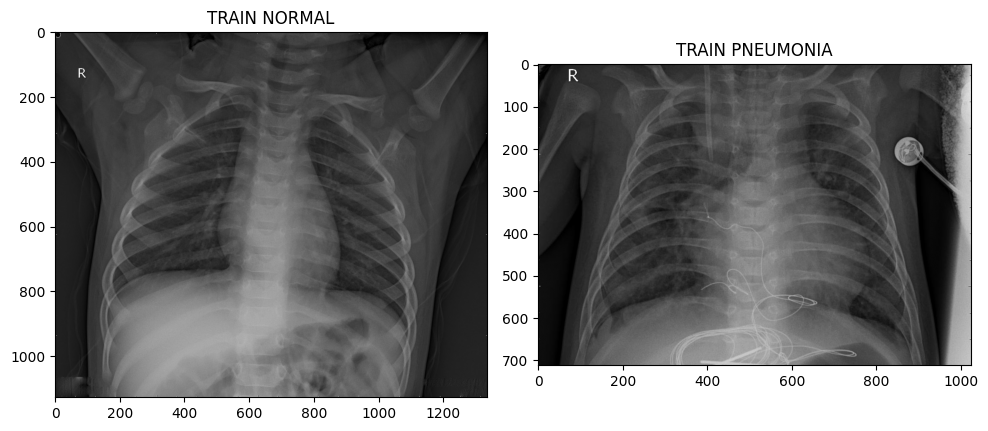

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
img1 = plt.imread(train_normal_dirs[0])
plt.imshow(img1, cmap='gray')
plt.title('TRAIN NORMAL')

plt.subplot(1, 2, 2)
img2 = plt.imread(train_pneumonia_dirs[0])
plt.imshow(img2, cmap='gray')
plt.title('TRAIN PNEUMONIA')

plt.tight_layout()
plt.show()

#### plotting nuber of images in each category

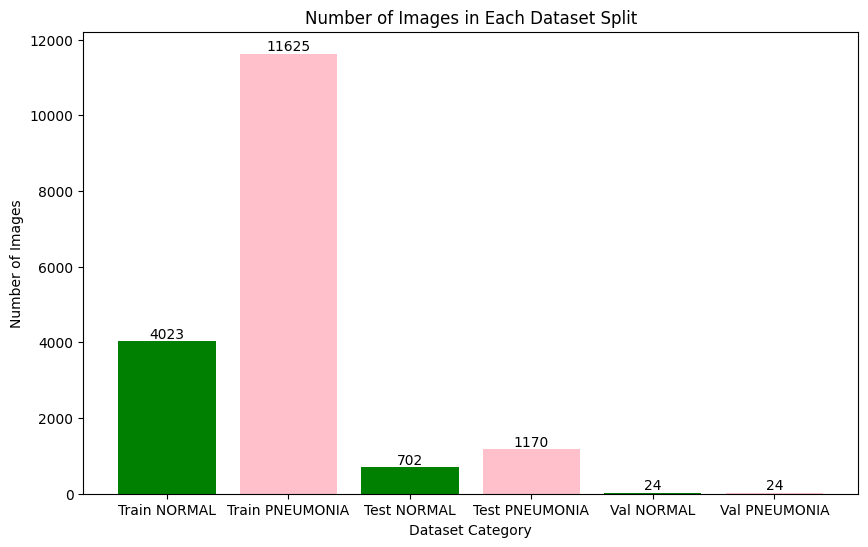

In [7]:
# Labels for the bars
labels = ['Train NORMAL', 'Train PNEUMONIA', 'Test NORMAL', 'Test PNEUMONIA', 'Val NORMAL', 'Val PNEUMONIA']

# Counts for each category
counts = [
    len(train_normal_dirs),
    len(train_pneumonia_dirs),
    len(test_normal_dirs),
    len(test_pneumonia_dirs),
    len(val_normal_dirs),
    len(val_pneumonia_dirs)
]

# Create bar plot
plt.figure(figsize=(10,6))
bars = plt.bar(labels, counts, color=['green', 'pink', 'green', 'pink', 'green', 'pink'])

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5, f'{int(height)}', ha='center', va='bottom')

plt.title('Number of Images in Each Dataset Split')
plt.xlabel('Dataset Category')
plt.ylabel('Number of Images')
plt.show()


Interpretaion of EDA: showing imbalance in data

In [8]:
# Image parameters
img_width, img_height = 150, 150
batch_size = 32

### Data augmentation to solve the problem of unbalancing

In [9]:
# Data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [10]:
# Validation and test generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_dirs = path+'/chest_xray/train'
test_dir = path+'/chest_xray/test'
val_dir = path+'/chest_xray/val'

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dirs,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.


In [13]:
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 16 images belonging to 2 classes.


In [14]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)  # Important for evaluation

Found 624 images belonging to 2 classes.


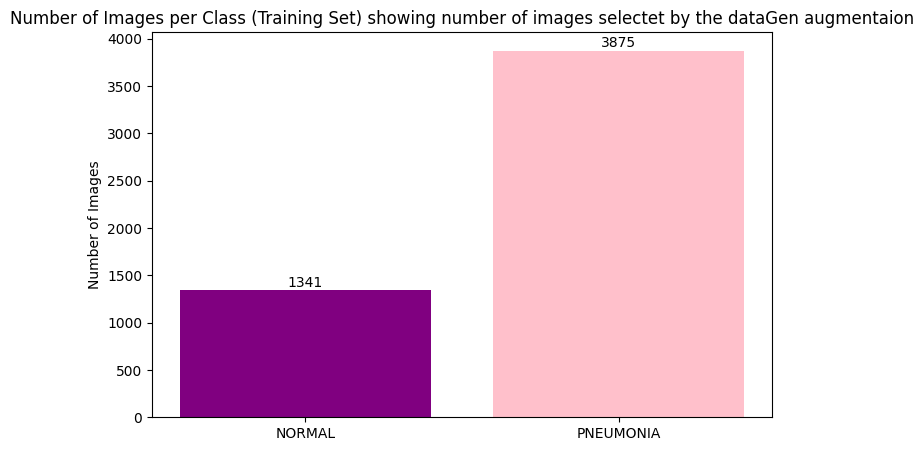

In [15]:
# Count images per class
labels = list(train_generator.class_indices.keys())
counts = [np.sum(train_generator.classes == v) for v in train_generator.class_indices.values()]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(labels, counts, color=['purple', 'pink'])

# Add count labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5, str(int(height)), ha='center', va='bottom')

plt.title('Number of Images per Class (Training Set) showing number of images selectet by the dataGen augmentaion')
plt.ylabel('Number of Images')
plt.show()


### Model architecture

In [16]:
def create_model():
    model = Sequential([
        # First convolution layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D(2, 2),

        # Second convolution layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Third convolution layer
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Fourth convolution layer
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Flatten and dense layers
        Flatten(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [17]:
model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

### training

In [19]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.7128 - auc: 0.5900 - loss: 0.5782 - precision: 0.7482 - recall: 0.9137

163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 608ms/step - accuracy: 0.7131 - auc: 0.5909 - loss: 0.5776 - precision: 0.7485 - recall: 0.9138 - val_accuracy: 0.7500 - val_auc: 0.9062 - val_loss: 0.6854 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.8409 - auc: 0.8978 - loss: 0.3458 - precision: 0.8990 - recall: 0.8861 - val_accuracy: 0.6250 - val_auc: 0.9062 - val_loss: 0.6979 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 428ms/step - accuracy: 0.8616 - auc: 0.9254 - loss: 0.3026 - precision: 0.9068 - recall: 0.9077 - val_accuracy: 0.6250 - val_auc: 0.8906 - val_loss: 0.6266 - val_precision: 0.5833 - val_recall: 0.8750
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8809 - auc: 0.9388 - loss: 0.2738 - precision: 0.9194 - recall: 0.9206

163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 432ms/step - accuracy: 0.8809 - auc: 0.9388 - loss: 0.2738 - precision: 0.9194 - recall: 0.9206 - val_accuracy: 0.8125 - val_auc: 0.9375 - val_loss: 0.3579 - val_precision: 0.7778 - val_recall: 0.8750
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.8887 - auc: 0.9433 - loss: 0.2656 - precision: 0.9341 - recall: 0.9146 - val_accuracy: 0.8125 - val_auc: 0.8906 - val_loss: 0.4181 - val_precision: 0.7778 - val_recall: 0.8750
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 429ms/step - accuracy: 0.8948 - auc: 0.9525 - loss: 0.2414 - precision: 0.9347 - recall: 0.9208 - val_accuracy: 0.7500 - val_auc: 0.9297 - val_loss: 0.6339 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9051 - auc: 0.9583 - loss: 0.2304 - precision: 0.9368 - recall: 0.9345

163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 427ms/step - accuracy: 0.9050 - auc: 0.9582 - loss: 0.2304 - precision: 0.9367 - recall: 0.9344 - val_accuracy: 0.8750 - val_auc: 0.9375 - val_loss: 0.4429 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 424ms/step - accuracy: 0.8976 - auc: 0.9531 - loss: 0.2408 - precision: 0.9392 - recall: 0.9209 - val_accuracy: 0.7500 - val_auc: 0.9375 - val_loss: 0.3780 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 430ms/step - accuracy: 0.9081 - auc: 0.9635 - loss: 0.2105 - precision: 0.9495 - recall: 0.9266 - val_accuracy: 0.8125 - val_auc: 0.9297 - val_loss: 0.5904 - val_precision: 0.7778 - val_recall: 0.8750


### Loading the model

In [20]:
# Load best model
model = tf.keras.models.load_model('best_model.h5')

# Evaluate on test set
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.8604 - auc: 0.6350 - loss: 0.4343 - precision: 0.5000 - recall: 0.6429
Test Accuracy: 88.78%
Test AUC: 0.9434
Test Precision: 0.8810
Test Recall: 0.9487


In [21]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step


### results

In [22]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.79      0.84       234
   Pneumonia       0.88      0.95      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



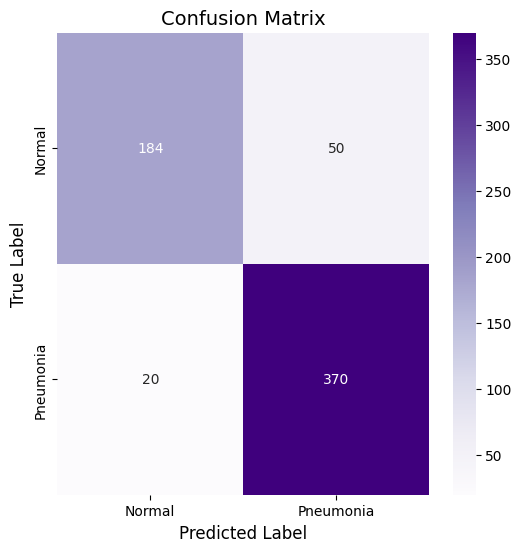

In [23]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a beautiful visualization
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

### LIME XAI technique

In [24]:
image_path = val_pneumonia_dirs[0]

In [29]:
def explain_with_lime(model, image_path, class_names, positive_only=True, num_features=5):

    explainer = lime_image.LimeImageExplainer()

    # Load and preprocess image
    img = keras_image.load_img(image_path, target_size=(150, 150))  # Match training size
    image = keras_image.img_to_array(img)
    if image.max() > 1.0:
        image = image / 255.0  # Normalize to [0,1]

    # Generate explanation
    explanation = explainer.explain_instance(
        image.astype('double'),
        lambda x: model.predict(x, verbose=0),
        top_labels=1,  # Only get explanation for the top predicted class
        hide_color=0,
        num_samples=1000
    )

    # Plot single explanation
    plt.figure(figsize=(5, 5))
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],  # Use the top predicted class
        positive_only=positive_only,
        num_features=num_features,
        hide_rest=False
    )
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"Explanation for {class_names[explanation.top_labels[0]]}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

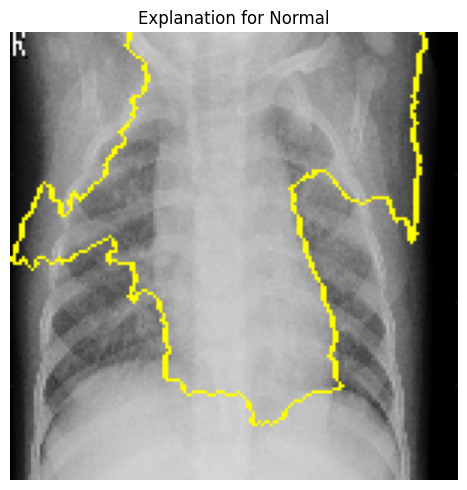

In [30]:
explain_with_lime(model, image_path, ['Normal', 'Pneumonia'])